# FIN 514 - Project 1 Choice #3 Python Codes
**Spring 2022**

This notebook provides the valuation of Auto-Callable Contingent Coupon Barrier Notes with
Memory Coupon Linked to the Nasdaq-100 Index®.

Team members: Ya-Yen,Li(yayenli2) / Wei Ting,Chao(wtchao3) / Yu-Shiuan,Chang(yschang4)

### Part a) Estimated value from LR model

### Part b) Volatility Sensitive Analysis

### Part c) Non-linearity 


## Packages and Configurations

The following common packages will be use on this notebook.

* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

# Part a) Estimated value from LR model

## Step 1 : Stock value tree with LR model  

In [2]:
N = 10001         # Number of steps
S0 = 15210.76     # Original Stock Price
sigma = 0.2713139 # Annualized (Future) Volatility of Stock Price Returns
r =  0.0060814    # Annualized Continously Compounded Risk-free Rate
T = 377/365       # Time Length of the Notes in which to Maturity (In Years)
D = 0.00725       # Continuous dividend yield
K = 0.75 * S0     # Strike Price

In [3]:
def Stock_tree(N, S0, sigma, r, T, D, K):
    
    # Create a two dimension array for stock prices
    stock_value = np.zeros([N+1, N+1])     
    
    # delta t
    delta = T / N    
    
    # Calculate d1 and d2
    d1 = ( np.log(S0 / K) + (r - D + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = ( np.log(S0 / K) + (r - D - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    # Calculate q and q_star where q=h(d2) and q_star=h(d1)
    q      = 1/2 + np.sign(d2) * np.sqrt(1/4 - 1/4 * np.exp(-(d2/(N + 1/3))**2 * (N + 1/6))) 
    q_star = 1/2 + np.sign(d1) * np.sqrt(1/4 - 1/4 * np.exp(-(d1/(N + 1/3))**2 * (N + 1/6)))  
    
    # Caculate u and d using q and q_star
    u = (np.exp( (r-D) * delta) * q_star) / q
    d = (np.exp( (r-D) * delta) - q * u) / (1 - q) 
    
    print("u = ", u, "d=", d)
    
    # Build the stock price tree
    stock_value[0,0] = S0
    for j in range (1,N+1):
        stock_value[j, 0] = stock_value[j-1, 0]*d 
        for i in range(1, j+1):    
            stock_value[j, i] = stock_value[j-1, i-1]*u      
        
    return stock_value

In [4]:
# Print u and d 
stock_value = Stock_tree(N, S0, sigma, r, T, D, K)

u =  1.0027322077219452 d= 0.997217867499275


In [5]:
# Print stock value tree 
stock_value

array([[1.52107600e+04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.51684417e+04, 1.52523190e+04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.51262410e+04, 1.52098850e+04, 1.52939915e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.21303667e-08, 1.21974443e-08, 1.22648928e-08, ...,
        1.07303239e+16, 0.00000000e+00, 0.00000000e+00],
       [1.20966184e-08, 1.21635094e-08, 1.22307702e-08, ...,
        1.07004707e+16, 1.07596414e+16, 0.00000000e+00],
       [1.20629640e-08, 1.21296689e-08, 1.21967426e-08, ...,
        1.06707006e+16, 1.07297067e+16, 1.07890390e+16]])

## Step 2 : Scenerios at Valuation date (2022/01/31)

In [4]:
Coupon = 22.20                          # Payements per coupon
Barrier = 0.75*S0                       # Coupon Barrier/ Trigger level
OB_dates = [104/365, 195/365, 286/365]  # Observation dates of autocall and coupon
PA_dates = [107/365, 198/365, 289/365]  # Payment dates of autocall and coupon
VoS = np.zeros((3,)*4)                  # Value of scenerios at valuation date (3*3*3*3 zeros matrix)

In [5]:
# Value of scenerios at valuation date (k, l, m, n) to track 
# 0 -> No Autocall + No coupon  
# 1 -> No Autocall + coupons
# 2 -> Autocall + coupons

for k in range(3):
    if k == 0: 
        VoS[k] = 1000  # 0000                                              
    if k == 1:
        VoS[k] = 1000 + 1 * Coupon * np.exp(r * 270/365)  # 1XXX
    # Autocall on 1st obsevation date   
    if k == 2:                                                                                                              
        VoS[k] = 1000 + 1 * Coupon * np.exp(r * 270/365)  # 2XXX           
        break  # Doesn't matter afterwards
        
    for l in range(3):
        if l == 0:                                            
            pass  # X0XX
        if l == 1:
            if k == 0:
                VoS[k, l] += 2 * Coupon * np.exp(r * 179/365)  # 01XX
            if k == 1:
                VoS[k, l] += 1 * Coupon * np.exp(r * 179/365)  # 11XX
        # Autocall on 2nd obsevation date
        if l == 2:                                                     
            if k == 0:
                VoS[k, l] += 2 * Coupon * np.exp(r * 179/365)  # 02XX
            if k == 1:
                VoS[k, l] += 1 * Coupon * np.exp(r * 179/365)  # 12XX
            break  # Doesn't matter afterwards
            
        for m in range(3):
            if m == 0:
                pass  # XX0X
            if m == 1:
                if l == 0:
                    if k == 0:
                        VoS[k, l, m] += 3 * Coupon * np.exp(r * 88/365)  # 001X
                    if k == 1:
                        VoS[k, l, m] += 2 * Coupon * np.exp(r * 88/365)  # 101X
                if l == 1:
                    VoS[k, l, m] += 1 * Coupon * np.exp(r * 88/365)      # X11X
            # Autocall on 3rd obsevation date
            if m == 2:                                                  
                if l == 0:
                    if k == 0:
                        VoS[k, l, m] += 3 * Coupon * np.exp(r * 88/365)  # 002X
                    if k == 1:
                        VoS[k, l, m] += 2 * Coupon * np.exp(r * 88/365)  # 102X
                if l == 1:
                    VoS[k, l, m] += 1 * Coupon * np.exp(r * 88/365)      # X12X
                break  # Doesn't matter afterwards
                
            for n in range(2):
                    if n == 0:
                        pass  # XXX0
                    if n == 1:
                        if m == 0:
                            if l == 0:
                                if k == 0:
                                    VoS[k, l, m, n] += 4 * Coupon   # 0001
                                if k == 1:
                                     VoS[k, l, m, n] += 3 * Coupon  # 1001
                            if l == 1:
                                VoS[k, l, m, n] += 2 * Coupon       # X101
                        if m == 1:
                             VoS[k, l, m, n] += 1 * Coupon          # XX11

In [6]:
VoS

array([[[[1000.        , 1088.8       , 1000.        ],
         [1066.69772058, 1088.89772058, 1066.69772058],
         [1066.69772058, 1066.69772058, 1066.69772058]],

        [[1044.53261556, 1088.93261556, 1044.53261556],
         [1066.76518909, 1088.96518909, 1066.76518909],
         [1066.76518909, 1066.76518909, 1066.76518909]],

        [[1044.53261556, 1044.53261556, 1044.53261556],
         [1044.53261556, 1044.53261556, 1044.53261556],
         [1044.53261556, 1044.53261556, 1044.53261556]]],


       [[[1022.30009322, 1088.90009322, 1022.30009322],
         [1066.76524027, 1088.96524027, 1066.76524027],
         [1066.76524027, 1066.76524027, 1066.76524027]],

        [[1044.566401  , 1088.966401  , 1044.566401  ],
         [1066.79897453, 1088.99897453, 1066.79897453],
         [1066.79897453, 1066.79897453, 1066.79897453]],

        [[1044.566401  , 1044.566401  , 1044.566401  ],
         [1044.566401  , 1044.566401  , 1044.566401  ],
         [1044.566401  , 1044.566401

In [7]:
# Iterate value of scenerios at valuation date (k,l,m,n = 3*3*3*2 matrix)
for k in range(3):
    for l in range(3):
        for m in range(3):
            for n in range(2):
                v = VoS[k, l, m, n]
                print(f"Index:{k},{l},{m},{n}; Value:{v}")

Index:0,0,0,0; Value:1000.0
Index:0,0,0,1; Value:1088.8
Index:0,0,1,0; Value:1066.6977205779694
Index:0,0,1,1; Value:1088.8977205779695
Index:0,0,2,0; Value:1066.6977205779694
Index:0,0,2,1; Value:1066.6977205779694
Index:0,1,0,0; Value:1044.5326155601686
Index:0,1,0,1; Value:1088.9326155601686
Index:0,1,1,0; Value:1066.7651890861584
Index:0,1,1,1; Value:1088.9651890861585
Index:0,1,2,0; Value:1066.7651890861584
Index:0,1,2,1; Value:1066.7651890861584
Index:0,2,0,0; Value:1044.5326155601686
Index:0,2,0,1; Value:1044.5326155601686
Index:0,2,1,0; Value:1044.5326155601686
Index:0,2,1,1; Value:1044.5326155601686
Index:0,2,2,0; Value:1044.5326155601686
Index:0,2,2,1; Value:1044.5326155601686
Index:1,0,0,0; Value:1022.3000932203313
Index:1,0,0,1; Value:1088.9000932203312
Index:1,0,1,0; Value:1066.7652402723108
Index:1,0,1,1; Value:1088.965240272311
Index:1,0,2,0; Value:1066.7652402723108
Index:1,0,2,1; Value:1066.7652402723108
Index:1,1,0,0; Value:1044.5664010004155
Index:1,1,0,1; Value:1088

## Step 3 : Option value Tree with LR model

In [8]:
def Valuation(S0, T, r, sigma, N, K, stock_value, Coupon, Barrier, OB_dates, VoS):
    
    # List to save the results
    result = []  
       
    # Create object type array to track all scenarios (k,l,m,n) of the all option values
    option_value = np.empty([N+1, N+1], dtype=object) 
        
    # delta t
    delta = T / N    
    
    # Calculate d1 and d2
    d1 = ( np.log(S0 / K) + (r - D + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = ( np.log(S0 / K) + (r - D - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    # Calculate q and q_star where q=h(d2) and q_star=h(d1)
    q      = 1/2 + np.sign(d2) * np.sqrt(1/4 - 1/4 * np.exp(-(d2/(N + 1/3))**2 * (N + 1/6))) 
    q_star = 1/2 + np.sign(d1) * np.sqrt(1/4 - 1/4 * np.exp(-(d1/(N + 1/3))**2 * (N + 1/6)))  
    
    # Caculate u and d using q and q_star
    u = (np.exp( (r-D) * delta) * q_star) / q
    d = (np.exp( (r-D) * delta) - q * u) / (1 - q) 
    
    # Calculate risk-neutal probability q 
    qu = (np.exp(r*delta)-d)/(u-d)
    
    # Observation dates in integers
    ob1 = [j/delta for j in OB_dates]
    ob = [int(j) for j in ob1]
    
    # At valuation date
    j = N
    for i in range(0, j+1): 
        if stock_value[j, i] >= Barrier:
            option_value[j, i] = VoS[:,:,:,1]
        if stock_value[j, i] < Barrier:
            option_value[j, i] = VoS[:,:,:,0] + (stock_value[j, i] / S0 - 1)*1000           
    
    # Calculate backward 
    for j in range(N-1, -1, -1):
        for i in range(0, j+1): 
            v = np.exp(-r * delta) * (qu * option_value[j + 1, i + 1] + (1-qu) * option_value[j + 1, i])
            
            # Memory and autocall features
            # On 3rd observation date
            if j == ob[2]:  
                if stock_value[j, i] >= S0:  # Autocall
                    v = v[:,:,2]  
                if S0 > stock_value[j, i] >= Barrier:
                    v = v[:,:,1]
                if stock_value[j, i] < Barrier:
                    v = v[:,:,0]
                    
            # On 2nd observation date
            if j == ob[1]:  
                if stock_value[j, i] >= S0:  # Autocall
                    v = v[:,2]  
                if S0 > stock_value[j, i] >= Barrier:
                    v = v[:,1]
                if stock_value[j, i] < Barrier:
                    v = v[:,0]
                    
            # On 1st observation date
            if j == ob[0]:  
                if stock_value[j, i] >= S0:  # Autocall
                    v = v[2]  # Autocall
                if S0 > stock_value[j, i] >= Barrier:
                    v = v[1]
                if stock_value[j, i] < Barrier:
                    v = v[0]
                    
            option_value[j, i] = v
            
    output = {'num_steps': N, 'Value': option_value[0,0]}

    return output

In [11]:
# Estimate value from LR model
Estimated_value = Valuation(S0, T, r, sigma, N, K, stock_value, Coupon, Barrier, OB_dates, VoS)
Estimated_value

{'num_steps': 10001, 'Value': 976.3828769212416}

# Part b) Volatility Sensitive Analysis

In [37]:
# Volatities from obersavation dates 
vol = [0.3915633, 0.2627887,  # 2022/05/03
       0.3625552, 0.2603371,  # 2022/11/01
       0.3508948, 0.2762897,  # 2022/08/02
       0.3383119, 0.2713139]  # 2023/01/31

In [38]:
# List to save the value 
value_result = []

# Value with different volatilities
for i in vol:
    stock_value = Stock_tree(N, S0, i, r, T, D, K)
    note_value = Valuation(S0, T, r, i, N, K, stock_value, Coupon, Barrier, OB_dates, VoS)
    output = {'Volatility': i, 'Value': note_value["Value"]}
    value_result.append(output)

u =  1.0039582829733922 d= 0.9960000239211328
u =  1.0026453415858703 d= 0.9973042634155393
u =  1.0036623748165503 d= 0.9962936729994368
u =  1.0026203628302008 d= 0.9973291097287079
u =  1.0035434532526992 d= 0.9964117354523022
u =  1.0027829113734383 d= 0.9971674452327575
u =  1.0034151392947928 d= 0.9965391538342594
u =  1.0027322077219452 d= 0.997217867499275


In [39]:
# Print value with different volatilities
value_result

[{'Volatility': 0.3915633, 'Value': 914.0478511348128},
 {'Volatility': 0.2627887, 'Value': 980.6306901793158},
 {'Volatility': 0.3625552, 'Value': 928.8718283831276},
 {'Volatility': 0.2603371, 'Value': 981.9749045615434},
 {'Volatility': 0.3508948, 'Value': 935.0732606694463},
 {'Volatility': 0.2762897, 'Value': 973.9938705451515},
 {'Volatility': 0.3383119, 'Value': 941.4141813771486},
 {'Volatility': 0.2713139, 'Value': 976.3828769212416}]

# Part c) Non-linearity 

***Compared to CRR and LR Model with steps from 50 to 1000***

In [12]:
start_step = 50  # start_step
end_step = 1000  # end_step

## Step : 1 Compared to CRR Model

In [13]:
def CRR(S0, T, r, D, sigma, start_step, end_step, Coupon, Barrier, OB_dates, VoS):
    
    # List to save the results
    crr_result = []  
       
    # Create object type array to track all scenarios (k,l,m,n) of the all option values
    option_value = np.empty([end_step+1, end_step+1], dtype=object) 
    
    for n in range(start_step, end_step+1):
        
        # delta t
        delta = T/n
        
        # Caculate u and d (CRR model)
        u = np.exp( sigma * (delta)**0.5)
        d = 1/u
        
        # Calculate risk-neutal probability q 
        qu = (np.exp( (r - D) * delta ) - d) / (u - d) 
        
        # CREATE ARRAY FOR STOCK PRICES OF SIZE N+1,N+1
        stock_value = np.zeros([n+1, n+1])    
        
        # Calculate stock value tree
        for j in range (0,n+1):
            for i in range(0, j+1):    
                stock_value[j,i] = S0*(u**i)*(d**(j-i))

        # Observation dates in integers
        ob1 = [j/delta for j in OB_dates]
        ob = [int(j) for j in ob1]

        # At valuation date
        j = n
        for i in range(0, j+1): 
            if stock_value[j, i] >= Barrier:
                option_value[j, i] = VoS[:,:,:,1]
            if stock_value[j, i] < Barrier:
                option_value[j, i] = VoS[:,:,:,0] + (stock_value[j, i] / S0 - 1)*1000           

        # Calculate backward 
        for j in range(n-1, -1, -1):
            for i in range(0, j+1): 
                v = np.exp(-r * delta) * (qu * option_value[j + 1, i + 1] + (1-qu) * option_value[j + 1, i])

                # Memory and autocall features
                # On 3rd observation date
                if j == ob[2]:  
                    if stock_value[j, i] >= S0:  # Autocall
                        v = v[:,:,2]  
                    if S0 > stock_value[j, i] >= Barrier:
                        v = v[:,:,1]
                    if stock_value[j, i] < Barrier:
                        v = v[:,:,0]

                # On 2nd observation date
                if j == ob[1]:  
                    if stock_value[j, i] >= S0:  # Autocall
                        v = v[:,2]  
                    if S0 > stock_value[j, i] >= Barrier:
                        v = v[:,1]
                    if stock_value[j, i] < Barrier:
                        v = v[:,0]

                # On 1st observation date
                if j == ob[0]:  
                    if stock_value[j, i] >= S0:  # Autocall
                        v = v[2]  # Autocall
                    if S0 > stock_value[j, i] >= Barrier:
                        v = v[1]
                    if stock_value[j, i] < Barrier:
                        v = v[0]

                option_value[j, i] = v
            
        output = {'num_steps': n, 'CRR_value': option_value[0,0]}
        crr_result.append(output)

    return crr_result

In [17]:
CRR_results = CRR(S0, T, r, D, sigma, start_step, end_step, Coupon, Barrier, OB_dates, VoS)
CRR_results

[{'num_steps': 50, 'CRR_value': 970.5856169971823},
 {'num_steps': 51, 'CRR_value': 973.5220230613194},
 {'num_steps': 52, 'CRR_value': 965.1607717024018},
 {'num_steps': 53, 'CRR_value': 972.9910939974484},
 {'num_steps': 54, 'CRR_value': 962.4789984967592},
 {'num_steps': 55, 'CRR_value': 977.5105655297311},
 {'num_steps': 56, 'CRR_value': 966.987896458999},
 {'num_steps': 57, 'CRR_value': 975.0970288188403},
 {'num_steps': 58, 'CRR_value': 964.9641082541245},
 {'num_steps': 59, 'CRR_value': 969.2742004164234},
 {'num_steps': 60, 'CRR_value': 986.0979289238545},
 {'num_steps': 61, 'CRR_value': 976.9243939091632},
 {'num_steps': 62, 'CRR_value': 982.1547343362429},
 {'num_steps': 63, 'CRR_value': 972.39281450564},
 {'num_steps': 64, 'CRR_value': 980.2252700970433},
 {'num_steps': 65, 'CRR_value': 969.7779404335839},
 {'num_steps': 66, 'CRR_value': 984.121451638922},
 {'num_steps': 67, 'CRR_value': 964.58521137905},
 {'num_steps': 68, 'CRR_value': 973.252435659137},
 {'num_steps': 69, 

In [18]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df_CRR = pd.DataFrame.from_dict(CRR_results)

In [19]:
# Type of the value
type(Estimated_value)

dict

In [20]:
# CALCULATE THE ERROR
df_CRR['error_CRR'] = Estimated_value['Value'] - df_CRR['CRR_value']

In [21]:
# INSPECT THE FIRST ROWS OF THE DATAFRAME
df_CRR.head()

,num_steps,CRR_value,error_CRR
0,50,970.585617,5.797260
1,51,973.522023,2.860854
2,52,965.160772,11.222105
3,53,972.991094,3.391783
4,54,962.478998,13.903878


In [22]:
# INSPECT THE LAST ROWS OF THE DATAFRAME
df_CRR.tail()

,num_steps,CRR_value,error_CRR
946,996,974.838887,1.543989
947,997,971.769484,4.613393
948,998,974.146462,2.236415
949,999,971.270041,5.112836
950,1000,973.926557,2.456320


In [23]:
# EXPORT THE DATA TO A CSV FILE
df_CRR.to_csv("/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/crr.csv", index=False)

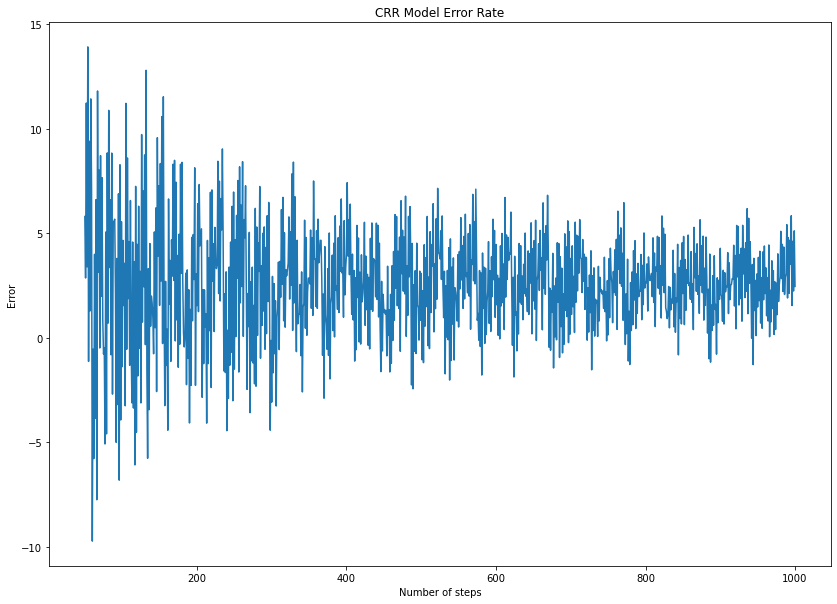

In [24]:
# Binomial Model Error Rate
plt.figure(figsize=(14,10))
plt.plot(df_CRR['num_steps'], df_CRR['error_CRR'], '-', markersize=3)
plt.title("CRR Model Error Rate")
plt.xlabel("Number of steps")
plt.ylabel("Error")
plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/crr.png')
plt.show()

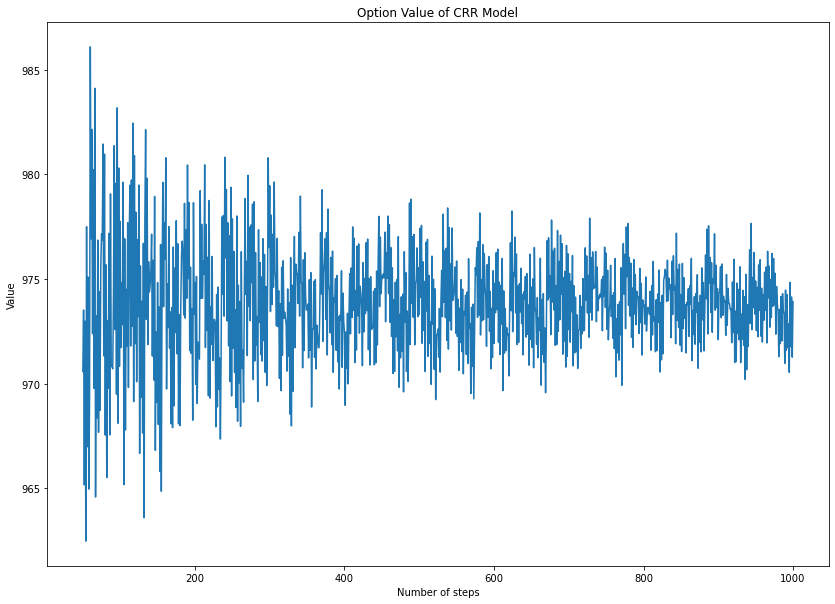

In [25]:
# Binomial Model Option Value
plt.figure(figsize=(14,10))
plt.plot(df_CRR['num_steps'], df_CRR['CRR_value'], '-', markersize=3)
plt.title("Option Value of CRR Model")
plt.xlabel("Number of steps")
plt.ylabel("Value")
plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/crr_value.png')
plt.show()

## Step : 2 Compared to LR Model

In [27]:
def LR(S0, K, T, r, D, sigma, start_step, end_step, Coupon, Barrier, OB_dates, VoS):
    
    # List to save the results
    lr_result = []  
       
    # Create object type array to track all scenarios (k,l,m,n) of the all option values
    option_value = np.empty([end_step+1, end_step+1], dtype=object) 
    
    # Calculate d1 and d2
    d1 = ( np.log(S0 / K) + (r - D + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = ( np.log(S0 / K) + (r - D - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    for n in range(start_step, end_step+1):
        
        # When n is odd
        if n % 2 == 1: 
            
            # delta t
            delta = T/n

            # Calculate q and q_star where q=h(d2) and q_star=h(d1)
            q      = 1/2 + np.sign(d2) * np.sqrt(1/4 - 1/4 * np.exp(-(d2/(n + 1/3))**2 * (n + 1/6))) 
            q_star = 1/2 + np.sign(d1) * np.sqrt(1/4 - 1/4 * np.exp(-(d1/(n + 1/3))**2 * (n + 1/6)))  

            # Caculate u and d using q and q_star
            u = (np.exp( (r - D) * delta) * q_star) / q
            d = (np.exp( (r - D) * delta) - q * u) / (1 - q) 

            # CREATE ARRAY FOR STOCK PRICES OF SIZE N+1,N+1
            stock_value = np.zeros([n+1, n+1])    

            # Calculate stock value tree
            for j in range (0, n+1):
                for i in range(0, j+1):    
                    stock_value[j,i] = S0*(u**i)*(d**(j-i))

            # Observation dates in integers
            ob1 = [j/delta for j in OB_dates]
            ob = [int(j) for j in ob1]

            # At valuation date
            j = n
            for i in range(0, j+1): 
                if stock_value[j, i] >= Barrier:
                    option_value[j, i] = VoS[:,:,:,1]
                if stock_value[j, i] < Barrier:
                    option_value[j, i] = VoS[:,:,:,0] + (stock_value[j, i] / S0 - 1)*1000           

            # Calculate backward 
            for j in range(n-1, -1, -1):
                for i in range(0, j+1): 
                    v = np.exp(-r * delta) * (q * option_value[j + 1, i + 1] + (1 - q) * option_value[j + 1, i])

                    # Memory and autocall features
                    # On 3rd observation date
                    if j == ob[2]:  
                        if stock_value[j, i] >= S0:  # Autocall
                            v = v[:,:,2]  
                        if S0 > stock_value[j, i] >= Barrier:
                            v = v[:,:,1]
                        if stock_value[j, i] < Barrier:
                            v = v[:,:,0]

                    # On 2nd observation date
                    if j == ob[1]:  
                        if stock_value[j, i] >= S0:  # Autocall
                            v = v[:,2]  
                        if S0 > stock_value[j, i] >= Barrier:
                            v = v[:,1]
                        if stock_value[j, i] < Barrier:
                            v = v[:,0]

                    # On 1st observation date
                    if j == ob[0]:  
                        if stock_value[j, i] >= S0:  # Autocall
                            v = v[2]  # Autocall
                        if S0 > stock_value[j, i] >= Barrier:
                            v = v[1]
                        if stock_value[j, i] < Barrier:
                            v = v[0]

                    option_value[j, i] = v

            output = {'num_steps': n, 'LR_value': option_value[0,0]}
            lr_result.append(output)

    return lr_result

In [27]:
LR_results = LR(S0, K, T, r, D, sigma, start_step, end_step, Coupon, Barrier, OB_dates, VoS)
LR_results

[{'num_steps': 51, 'LR_value': 975.3747446264216},
 {'num_steps': 53, 'LR_value': 969.0529646037826},
 {'num_steps': 55, 'LR_value': 972.2443020798246},
 {'num_steps': 57, 'LR_value': 973.6393400495542},
 {'num_steps': 59, 'LR_value': 977.6883606493386},
 {'num_steps': 61, 'LR_value': 977.7042619154213},
 {'num_steps': 63, 'LR_value': 973.9259624170616},
 {'num_steps': 65, 'LR_value': 972.5704171054671},
 {'num_steps': 67, 'LR_value': 978.1345093937283},
 {'num_steps': 69, 'LR_value': 972.5708885453388},
 {'num_steps': 71, 'LR_value': 972.9547251380094},
 {'num_steps': 73, 'LR_value': 974.7711368114741},
 {'num_steps': 75, 'LR_value': 976.9383525925491},
 {'num_steps': 77, 'LR_value': 971.7552805472841},
 {'num_steps': 79, 'LR_value': 972.1310462615687},
 {'num_steps': 81, 'LR_value': 974.5656371852194},
 {'num_steps': 83, 'LR_value': 975.917146968866},
 {'num_steps': 85, 'LR_value': 971.2673795736956},
 {'num_steps': 87, 'LR_value': 975.6636801573565},
 {'num_steps': 89, 'LR_value': 9

In [28]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df_LR = pd.DataFrame.from_dict(LR_results)

In [29]:
# CALCULATE THE ERROR
df_LR['error_LR'] = Estimated_value['Value'] - df_LR['LR_value']

In [30]:
# INSPECT THE FIRST ROWS OF THE DATAFRAME
df_LR.head()

,num_steps,LR_value,error_LR
0,51,975.374745,1.008132
1,53,969.052965,7.329912
2,55,972.244302,4.138575
3,57,973.639340,2.743537
4,59,977.688361,-1.305484


In [31]:
# INSPECT THE LAST ROWS OF THE DATAFRAME
df_LR.tail()

,num_steps,LR_value,error_LR
470,991,974.652118,1.730759
471,993,974.409242,1.973635
472,995,973.677007,2.705870
473,997,974.951735,1.431142
474,999,974.581448,1.801429


In [32]:
# EXPORT THE DATA TO A CSV FILE
df_LR.to_csv("/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/lr.csv", index=False)

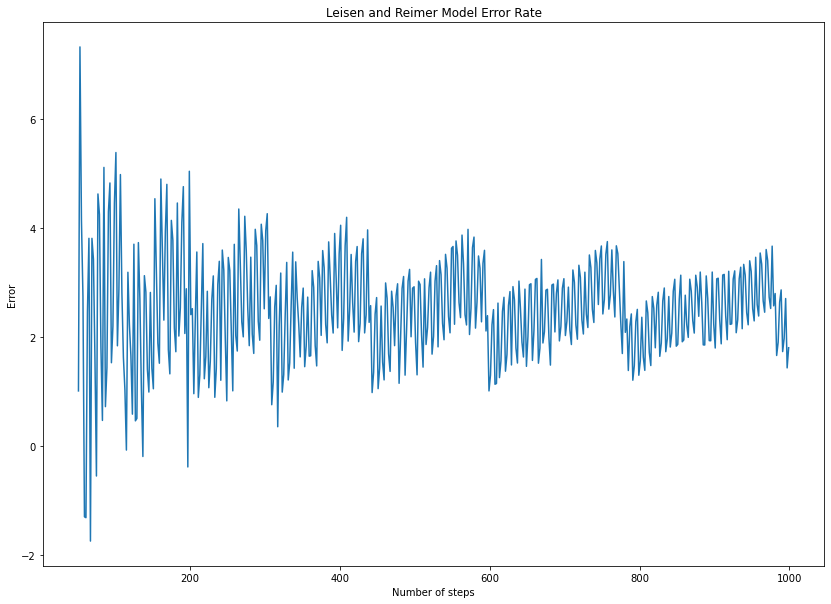

In [33]:
# Binomial Model Error Rate
plt.figure(figsize=(14,10))
plt.plot(df_LR['num_steps'], df_LR['error_LR'], '-', markersize=3)
plt.title("Leisen and Reimer Model Error Rate")
plt.xlabel("Number of steps")
plt.ylabel("Error")
plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/lr.png')
plt.show()

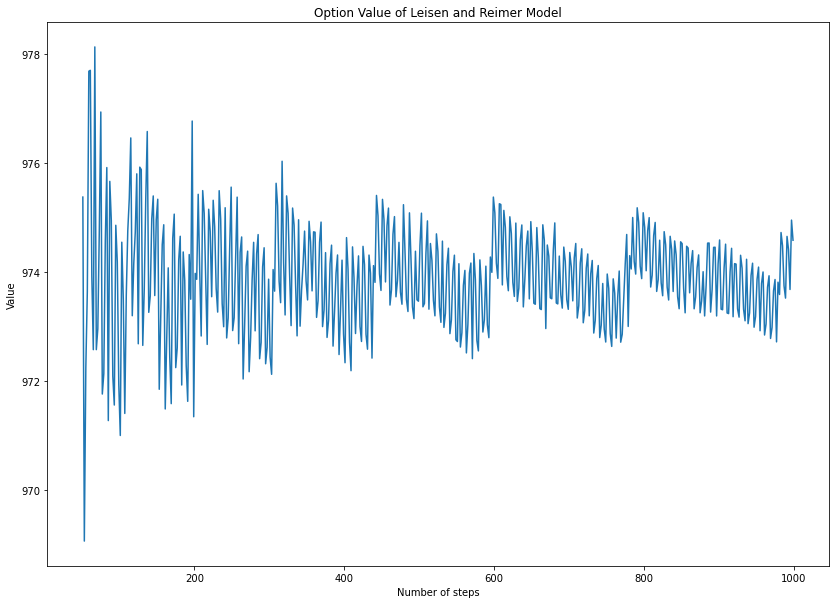

In [34]:
# Binomial Model Option Value
plt.figure(figsize=(14,10))
plt.plot(df_LR['num_steps'], df_LR['LR_value'], '-', markersize=3)
plt.title("Option Value of Leisen and Reimer Model")
plt.xlabel("Number of steps")
plt.ylabel("Value")
plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/lr_value.png')
plt.show()

# Non-linearity with Correct Volatility

**Using at-the-money volatility on the second observation date 08/02/2022, which is 0.2603371.**

In [9]:
new_sigma = 0.2603371

In [10]:
stock_value_new = Stock_tree(N, S0, new_sigma, r, T, D, K)
stock_value_new

u =  1.0026203628302008 d= 0.9973291097287079


array([[1.52107600e+04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.51701337e+04, 1.52506177e+04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.51296160e+04, 1.52098850e+04, 1.52905799e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.70054066e-08, 3.72017359e-08, 3.73991069e-08, ...,
        3.51739856e+15, 0.00000000e+00, 0.00000000e+00],
       [3.69065692e-08, 3.71023742e-08, 3.72992180e-08, ...,
        3.50800398e+15, 3.52661542e+15, 0.00000000e+00],
       [3.68079958e-08, 3.70032778e-08, 3.71995959e-08, ...,
        3.49863448e+15, 3.51719622e+15, 3.53585644e+15]])

In [19]:
Estimated_value_new = Valuation(S0, T, r, new_sigma, N, K, stock_value_new, Coupon, Barrier, OB_dates, VoS)
Estimated_value_new

{'num_steps': 10001, 'Value': 981.9749045615434}

## CRR Model

In [16]:
new_CRR_results = CRR(S0, T, r, D, new_sigma, start_step, end_step, Coupon, Barrier, OB_dates, VoS)
new_CRR_results

[{'num_steps': 50, 'CRR_value': 973.2691895952962},
 {'num_steps': 51, 'CRR_value': 975.8660088657607},
 {'num_steps': 52, 'CRR_value': 976.6485369275921},
 {'num_steps': 53, 'CRR_value': 984.40148989623},
 {'num_steps': 54, 'CRR_value': 965.2701406490715},
 {'num_steps': 55, 'CRR_value': 978.1092991145066},
 {'num_steps': 56, 'CRR_value': 986.4424720807971},
 {'num_steps': 57, 'CRR_value': 977.5964550846231},
 {'num_steps': 58, 'CRR_value': 986.085562278953},
 {'num_steps': 59, 'CRR_value': 982.6454724004162},
 {'num_steps': 60, 'CRR_value': 988.3246591957496},
 {'num_steps': 61, 'CRR_value': 971.0813221247614},
 {'num_steps': 62, 'CRR_value': 984.431497424861},
 {'num_steps': 63, 'CRR_value': 975.0305686774268},
 {'num_steps': 64, 'CRR_value': 982.5501337735448},
 {'num_steps': 65, 'CRR_value': 972.4605384640524},
 {'num_steps': 66, 'CRR_value': 976.2378705661753},
 {'num_steps': 67, 'CRR_value': 977.3725605460442},
 {'num_steps': 68, 'CRR_value': 975.671068830383},
 {'num_steps': 69

In [17]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df_CRR_new = pd.DataFrame.from_dict(new_CRR_results)

In [20]:
# CALCULATE THE ERROR
df_CRR_new['error_CRR'] = Estimated_value_new['Value'] - df_CRR_new['CRR_value']

In [22]:
# EXPORT THE DATA TO A CSV FILE
df_CRR_new.to_csv("/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/crr_1.csv", index=False)

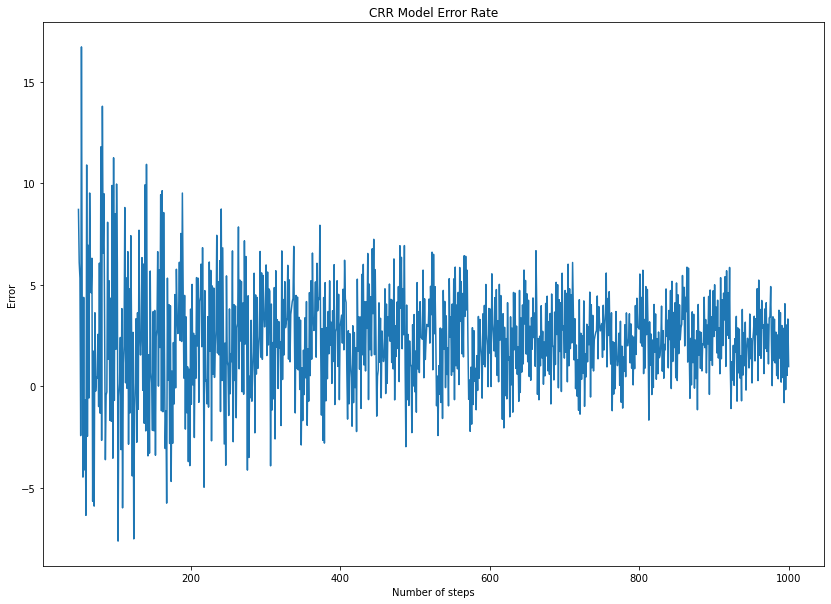

In [23]:
# Binomial Model Error Rate
plt.figure(figsize=(14,10))
plt.plot(df_CRR_new['num_steps'], df_CRR_new['error_CRR'], '-', markersize=3)
plt.title("CRR Model Error Rate")
plt.xlabel("Number of steps")
plt.ylabel("Error")
plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/crr_1.png')
plt.show()

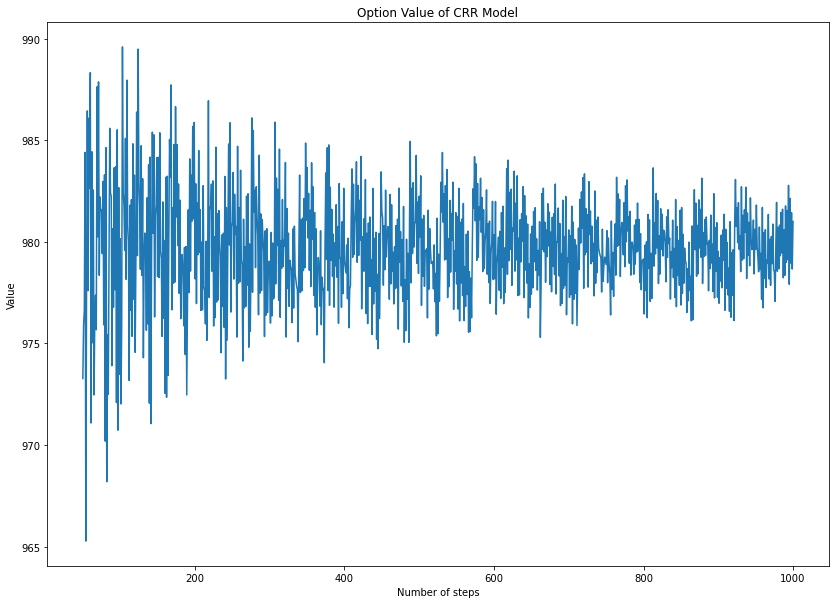

In [24]:
# Binomial Model Option Value
plt.figure(figsize=(14,10))
plt.plot(df_CRR_new['num_steps'], df_CRR_new['CRR_value'], '-', markersize=3)
plt.title("Option Value of CRR Model")
plt.xlabel("Number of steps")
plt.ylabel("Value")
plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/crr_value_1.png')
plt.show()

## LR Model

In [28]:
new_LR_results = LR(S0, K, T, r, D, new_sigma, start_step, end_step, Coupon, Barrier, OB_dates, VoS)
new_LR_results

[{'num_steps': 51, 'LR_value': 981.4228518265855},
 {'num_steps': 53, 'LR_value': 982.1854251430948},
 {'num_steps': 55, 'LR_value': 979.6391218477435},
 {'num_steps': 57, 'LR_value': 978.711702405062},
 {'num_steps': 59, 'LR_value': 984.5798710387174},
 {'num_steps': 61, 'LR_value': 982.7445955534633},
 {'num_steps': 63, 'LR_value': 978.9891647236062},
 {'num_steps': 65, 'LR_value': 977.6564154815605},
 {'num_steps': 67, 'LR_value': 983.1659510308594},
 {'num_steps': 69, 'LR_value': 977.6370026714927},
 {'num_steps': 71, 'LR_value': 978.0304368210972},
 {'num_steps': 73, 'LR_value': 979.8470745955121},
 {'num_steps': 75, 'LR_value': 981.9803200115659},
 {'num_steps': 77, 'LR_value': 976.8345679354953},
 {'num_steps': 79, 'LR_value': 978.1180203754473},
 {'num_steps': 81, 'LR_value': 979.6562528359473},
 {'num_steps': 83, 'LR_value': 980.9693883918369},
 {'num_steps': 85, 'LR_value': 977.9121766380015},
 {'num_steps': 87, 'LR_value': 980.7337275437023},
 {'num_steps': 89, 'LR_value': 9

In [29]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df_LR_new = pd.DataFrame.from_dict(new_LR_results)

In [32]:
# CALCULATE THE ERROR
df_LR_new['error_LR'] = Estimated_value_new['Value'] - df_LR_new['LR_value']

In [33]:
# EXPORT THE DATA TO A CSV FILE
df_LR_new.to_csv("/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/lr_1.csv", index=False)

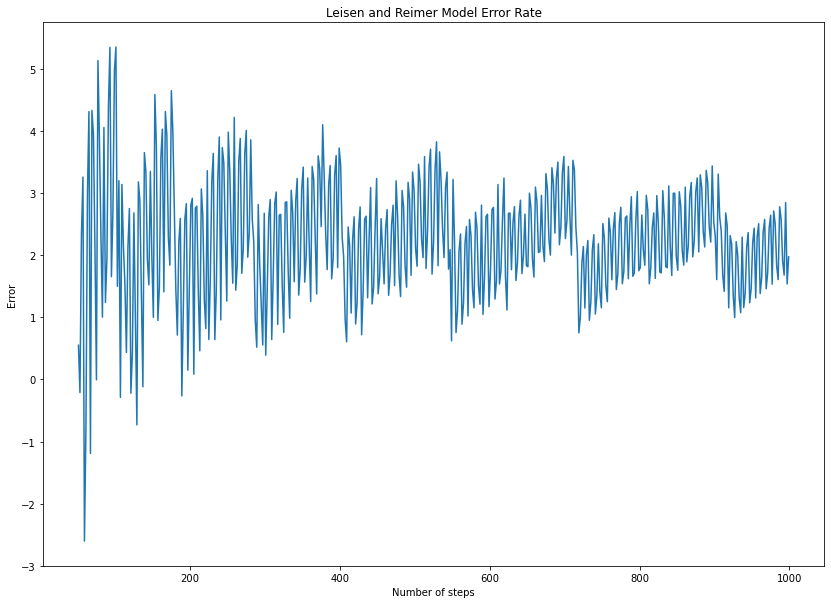

In [35]:
# Binomial Model Error Rate
plt.figure(figsize=(14,10))
plt.plot(df_LR_new['num_steps'], df_LR_new['error_LR'], '-', markersize=3)
plt.title("Leisen and Reimer Model Error Rate")
plt.xlabel("Number of steps")
plt.ylabel("Error")
plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/lr_1.png')
plt.show()

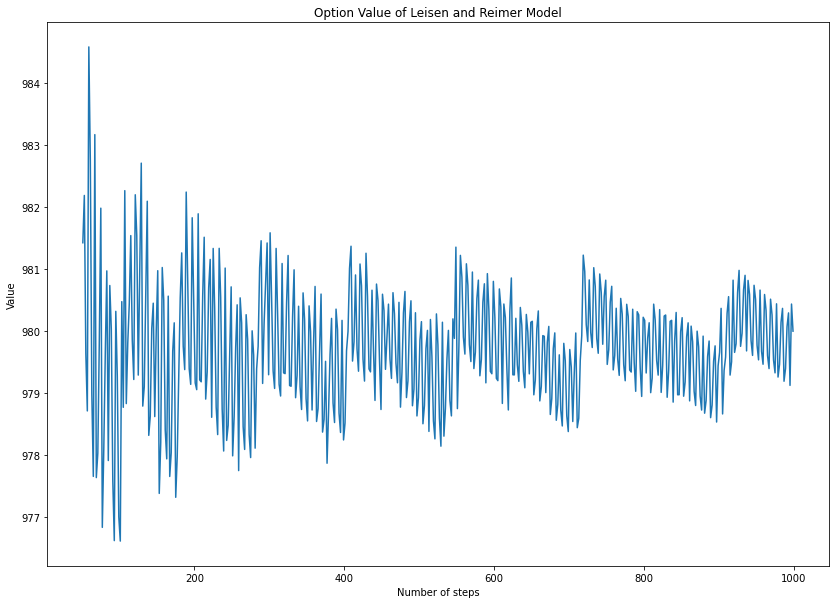

In [36]:
# Binomial Model Option Value
plt.figure(figsize=(14,10))
plt.plot(df_LR_new['num_steps'], df_LR_new['LR_value'], '-', markersize=3)
plt.title("Option Value of Leisen and Reimer Model")
plt.xlabel("Number of steps")
plt.ylabel("Value")
plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project1/lr_value_1.png')
plt.show()